In [2]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
import random


In [1]:
!pip install selectivesearch
# !pip install torch_snippets

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=3130439df29785b49228c4e932adddd09c180e945648e1b96f6094f34f60f543
  Stored in directory: /root/.cache/pip/wheels/7f/9b/c7/58b71f1e9fe4aa0ef8affd1c673f8818bc22a5091ea8cbbe93
Successfully built selectivesearch


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
from torchvision import transforms

# Example of resizing during training:
# transform = transforms.Compose([
#     transforms.ToTensor(),            # Convert the image to a tensor
#     transforms.Resize((800, 800))      # Resize to a fixed size (e.g., 800x800) or use a range for min/max sizes
# ])

# Apply this transform during dataset loading


In [6]:
from torchvision.transforms import functional as F
import torch

class ResizeWithBBox:
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        # Resize the image while maintaining the aspect ratio
        width, height = image.size
        aspect_ratio = width / height

        # Calculate new size for the image
        if aspect_ratio > 1:
            new_width = self.max_size
            new_height = int(self.max_size / aspect_ratio)
        else:
            new_height = self.max_size
            new_width = int(self.max_size * aspect_ratio)

        image = F.resize(image, (new_height, new_width))  # Resize the image

        # Convert PIL image to tensor
        image = F.to_tensor(image)

        # Resize the bounding boxes
        boxes = target['boxes']
        boxes = boxes * torch.tensor([new_width / width, new_height / height, new_width / width, new_height / height])

        # Update the target dictionary
        target['boxes'] = boxes

        return image, target

In [7]:
transform = ResizeWithBBox(min_size=800, max_size=1333)

In [10]:
class WeedDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'annotations' folders
            transforms (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.annotations_dir = os.path.join(root_dir, 'annotations')
        self.transforms = transforms

        # Create class to index mapping
        # Add 'background' as class 0 (required for Faster R-CNN)
        self.class_to_idx = {
            'background': 0,
            'carpetweed': 1,
            'morningglory': 2,
            'palmer_amaranth': 3
        }
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        # Get all JSON annotation files
        self.annotation_files = [f for f in os.listdir(self.annotations_dir)
                                if f.endswith('.json')]

        # Create a mapping of image files to their annotations
        self.samples = []
        for ann_file in self.annotation_files:
            ann_path = os.path.join(self.annotations_dir, ann_file)
            with open(ann_path, 'r') as f:
                data = json.load(f)

            # Extract the actual data (it's nested in a key)
            for key, value in data.items():
                img_filename = value['filename']
                img_path = os.path.join(self.images_dir, img_filename)

                # Only add if image exists
                if os.path.exists(img_path):
                    self.samples.append({
                        'image_path': img_path,
                        'annotation': value
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Image tensor
            target (dict): Dictionary containing:
                - boxes (FloatTensor[N, 4]): Bounding boxes in [x_min, y_min, x_max, y_max] format
                - labels (Int64Tensor[N]): Class labels
                - image_id (Tensor): Image identifier
                - area (Tensor): Area of each bounding box
                - iscrowd (UInt8Tensor[N]): Whether the box is a crowd (0 for all)
        """
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')

        # Extract annotations
        annotation = sample['annotation']
        regions = annotation.get('regions', [])

        boxes = []
        labels = []

        for region in regions:
            shape_attrs = region['shape_attributes']
            region_attrs = region['region_attributes']

            # Extract bounding box coordinates
            if shape_attrs['name'] == 'rect':
                x = shape_attrs['x']
                y = shape_attrs['y']
                width = shape_attrs['width']
                height = shape_attrs['height']

                # Convert to [x_min, y_min, x_max, y_max] format
                x_min = x
                y_min = y
                x_max = x + width
                y_max = y + height

                # Get class label
                class_name = region_attrs.get('class')

                # Only add box if class name is valid
                if class_name and class_name in self.class_to_idx:
                    boxes.append([x_min, y_min, x_max, y_max])
                    label = self.class_to_idx[class_name]
                    labels.append(label)
                else:
                    # Skip this annotation if class is missing or unknown
                    print(f"Warning: Unknown or missing class '{class_name}' in image {idx}, skipping annotation")


        # Handle edge case: if no valid boxes found, create empty tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.uint8)
        else:
            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Calculate area of each box
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            # iscrowd = 0 for all instances (not a crowd)
            iscrowd = torch.zeros((len(boxes),), dtype=torch.uint8)

        # Create image_id tensor
        image_id = torch.tensor([idx])

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transforms if any
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        else:
            # Convert PIL image to tensor
            image = transforms.ToTensor()(image)

        return image, target

    def get_class_name(self, idx):
        """Get class name from index"""
        return self.idx_to_class.get(idx, 'unknown')

    def get_num_classes(self):
        """Get total number of classes (including background)"""
        return len(self.class_to_idx)

    def get_image_path(self, idx):
        """Get the file path of an image"""
        # Need to adjust this to work with Subset if split_dataset is used
        # For now, assuming direct indexing into self.samples is okay when not using split
        if isinstance(idx, torch.utils.data.Subset):
             # This case won't happen with the corrected split_dataset
             pass
        else:
             return self.samples[idx]['image_path']


    def split_dataset(self, validation_split=0.3):
        """
        Splits the dataset into training and validation sets.

        Args:
            validation_split (float): Proportion of dataset to use for validation (default is 30%)

        Returns:
            train_dataset, val_dataset: Splitted datasets for training and validation
        """
        dataset_size = len(self)
        val_size = int(dataset_size * validation_split)
        train_size = dataset_size - val_size

        # Generate list of indices
        indices = list(range(dataset_size))
        random.shuffle(indices)

        # Create training and validation indices
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]

        # Create new datasets for train and validation
        train_dataset = WeedDatasetSubset(self, train_indices)
        val_dataset = WeedDatasetSubset(self, val_indices)

        return train_dataset, val_dataset



In [12]:
class WeedDatasetSubset(Dataset):
    def __init__(self, full_dataset, sample_indices):
        """
        Args:
            full_dataset (WeedDataset): The full dataset instance
            sample_indices (list): List of indices for a subset of the dataset
        """
        self.full_dataset = full_dataset
        self.sample_indices = sample_indices  # List of indices for the subset

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        # Get the actual index in the full dataset
        actual_index = self.sample_indices[idx]

        # Return the sample using full_dataset's __getitem__
        return self.full_dataset.__getitem__(actual_index)

Training the CNN

In [13]:
# Initialize dataset
print("Loading dataset...")
dataset = WeedDataset(root_dir=r'/content/drive/MyDrive/CottonWeedDet3')


Loading dataset...


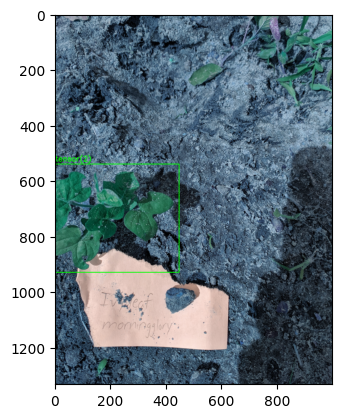

In [ ]:
img, tgt = dataset[4]
assert img.shape[0] == 3
assert tgt['boxes'].ndim == 2 and tgt['labels'].ndim == 1

img = img.permute(1, 2, 0).numpy()
img = (img * 255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for box, label in zip(tgt['boxes'], tgt['labels']):
    x1, y1, x2, y2 = box
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(img, str(label), (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(img)
plt.show()



In [14]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import backbone_utils
from torchvision.models.detection.rpn import AnchorGenerator

# Load ResNet-50 pre-trained on ImageNet with FPN
# `resnet50_fpn` automatically uses the FPN implementation
backbone_fpn = backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)

# Define the Faster R-CNN model with the backbone that includes FPN
model = FasterRCNN(
    backbone_fpn,
    num_classes=dataset.get_num_classes(),  # Including background as class 0
    min_size=800,  # The minimum size of the image during training
    max_size=1333, # The maximum size of the image during training
)

# Replace the predictor for classification and bounding box regression
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, dataset.get_num_classes())

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model.to(device)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
import torch

# Your training loop here

# At the end of training or each epoch:
del model
del optimizer

# Clean up GPU memory
torch.cuda.empty_cache()


NameError: name 'optimizer' is not defined

In [16]:
from torch.utils.data import random_split

In [17]:
# Split into training and validation datasets
train_dataset, val_dataset = dataset.split_dataset(validation_split=0.3)

In [18]:
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
import torch.optim as optim


In [19]:
# Define a custom collate_fn for detection models
def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn)

# Create DataLoader for validation set (no shuffling)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, collate_fn=collate_fn)

# Define optimizer (you may want to use Adam or SGD)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


In [20]:
# Set model to train mode
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [21]:
from tqdm import tqdm  # Importing tqdm for progress bars

# Training loop with progress bar
num_epochs = 10
for epoch in range(num_epochs):
    # Initialize running loss for each component
    running_loss_classifier = 0.0
    running_loss_box_reg = 0.0
    running_loss_objectness = 0.0
    running_loss_fpn_box_reg = 0.0
    running_total_loss = 0.0

    model.train()  # Ensure the model is in training mode
    epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)  # Progress bar for the epoch

    for images, targets in epoch_iterator:
        # Convert images to tensors and move them to the appropriate device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        loss_dict = model(images, targets)

        # Extract individual losses from the loss dictionary
        loss_classifier = loss_dict['loss_classifier']
        loss_box_reg = loss_dict['loss_box_reg']
        loss_objectness = loss_dict['loss_objectness']
        loss_fpn_box_reg = loss_dict['loss_fpn_box_reg']

        # Calculate total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass to compute gradients
        total_loss.backward()

        # Optimize the model using the optimizer
        optimizer.step()

        # Track running losses
        running_loss_classifier += loss_classifier.item() if isinstance(loss_classifier, torch.Tensor) else loss_classifier
        running_loss_box_reg += loss_box_reg.item() if isinstance(loss_box_reg, torch.Tensor) else loss_box_reg
        running_loss_objectness += loss_objectness.item() if isinstance(loss_objectness, torch.Tensor) else loss_objectness
        running_loss_fpn_box_reg += loss_fpn_box_reg.item() if isinstance(loss_fpn_box_reg, torch.Tensor) else loss_fpn_box_reg
        running_total_loss += total_loss.item() if isinstance(total_loss, torch.Tensor) else total_loss

        # Update the progress bar description with the current batch's losses
        epoch_iterator.set_postfix(
            loss_classifier=loss_classifier.item(),
            loss_box_reg=loss_box_reg.item(),
            loss_objectness=loss_objectness.item(),
            loss_rpn_box_reg=loss_fpn_box_reg.item(),
            total_loss=total_loss.item()
        )

    # Calculate average loss for the epoch
    num_batches = len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  - Average Loss Classifier: {running_loss_classifier / num_batches:.4f}")
    print(f"  - Average Loss Box Reg: {running_loss_box_reg / num_batches:.4f}")
    print(f"  - Average Loss Objectness: {running_loss_objectness / num_batches:.4f}")
    print(f"  - Average Loss FPN Box Reg: {running_loss_fpn_box_reg / num_batches:.4f}")
    print(f"  - Average Total Loss: {running_total_loss / num_batches:.4f}")

Epoch 1/10: 100%|██████████| 99/99 [14:45<00:00,  8.94s/it, loss_box_reg=0.147, loss_classifier=0.118, loss_objectness=0.0328, loss_rpn_box_reg=0.0433, total_loss=0.341]


Epoch [1/10]
  - Average Loss Classifier: 0.2045
  - Average Loss Box Reg: 0.1349
  - Average Loss Objectness: 0.0992
  - Average Loss RPN Box Reg: 0.0249
  - Average Total Loss: 0.4635


Epoch 2/10: 100%|██████████| 99/99 [10:45<00:00,  6.52s/it, loss_box_reg=0.109, loss_classifier=0.163, loss_objectness=0.0157, loss_rpn_box_reg=0.0136, total_loss=0.302]


Epoch [2/10]
  - Average Loss Classifier: 0.1762
  - Average Loss Box Reg: 0.1629
  - Average Loss Objectness: 0.0314
  - Average Loss RPN Box Reg: 0.0223
  - Average Total Loss: 0.3929


Epoch 3/10: 100%|██████████| 99/99 [10:39<00:00,  6.46s/it, loss_box_reg=0.105, loss_classifier=0.0949, loss_objectness=0.00662, loss_rpn_box_reg=0.00937, total_loss=0.216]


Epoch [3/10]
  - Average Loss Classifier: 0.1741
  - Average Loss Box Reg: 0.1545
  - Average Loss Objectness: 0.0208
  - Average Loss RPN Box Reg: 0.0197
  - Average Total Loss: 0.3691


Epoch 4/10: 100%|██████████| 99/99 [10:40<00:00,  6.47s/it, loss_box_reg=0.165, loss_classifier=0.198, loss_objectness=0.0139, loss_rpn_box_reg=0.0557, total_loss=0.432]


Epoch [4/10]
  - Average Loss Classifier: 0.1572
  - Average Loss Box Reg: 0.1429
  - Average Loss Objectness: 0.0184
  - Average Loss RPN Box Reg: 0.0187
  - Average Total Loss: 0.3372


Epoch 5/10: 100%|██████████| 99/99 [10:45<00:00,  6.52s/it, loss_box_reg=0.151, loss_classifier=0.131, loss_objectness=0.0173, loss_rpn_box_reg=0.018, total_loss=0.318]


Epoch [5/10]
  - Average Loss Classifier: 0.1431
  - Average Loss Box Reg: 0.1421
  - Average Loss Objectness: 0.0157
  - Average Loss RPN Box Reg: 0.0175
  - Average Total Loss: 0.3184


Epoch 6/10: 100%|██████████| 99/99 [10:37<00:00,  6.44s/it, loss_box_reg=0.16, loss_classifier=0.148, loss_objectness=0.0192, loss_rpn_box_reg=0.0109, total_loss=0.337]


Epoch [6/10]
  - Average Loss Classifier: 0.1311
  - Average Loss Box Reg: 0.1393
  - Average Loss Objectness: 0.0143
  - Average Loss RPN Box Reg: 0.0168
  - Average Total Loss: 0.3014


Epoch 7/10: 100%|██████████| 99/99 [10:41<00:00,  6.48s/it, loss_box_reg=0.0962, loss_classifier=0.0875, loss_objectness=0.00727, loss_rpn_box_reg=0.00666, total_loss=0.198]


Epoch [7/10]
  - Average Loss Classifier: 0.1196
  - Average Loss Box Reg: 0.1381
  - Average Loss Objectness: 0.0130
  - Average Loss RPN Box Reg: 0.0163
  - Average Total Loss: 0.2871


Epoch 8/10: 100%|██████████| 99/99 [10:39<00:00,  6.46s/it, loss_box_reg=0.185, loss_classifier=0.147, loss_objectness=0.0207, loss_rpn_box_reg=0.0154, total_loss=0.368]


Epoch [8/10]
  - Average Loss Classifier: 0.1083
  - Average Loss Box Reg: 0.1318
  - Average Loss Objectness: 0.0115
  - Average Loss RPN Box Reg: 0.0160
  - Average Total Loss: 0.2675


Epoch 9/10: 100%|██████████| 99/99 [10:49<00:00,  6.56s/it, loss_box_reg=0.136, loss_classifier=0.094, loss_objectness=0.00465, loss_rpn_box_reg=0.00612, total_loss=0.24]


Epoch [9/10]
  - Average Loss Classifier: 0.1022
  - Average Loss Box Reg: 0.1288
  - Average Loss Objectness: 0.0114
  - Average Loss RPN Box Reg: 0.0156
  - Average Total Loss: 0.2579


Epoch 10/10: 100%|██████████| 99/99 [10:40<00:00,  6.47s/it, loss_box_reg=0.0754, loss_classifier=0.0527, loss_objectness=0.00348, loss_rpn_box_reg=0.0142, total_loss=0.146]

Epoch [10/10]
  - Average Loss Classifier: 0.0882
  - Average Loss Box Reg: 0.1244
  - Average Loss Objectness: 0.0090
  - Average Loss RPN Box Reg: 0.0142
  - Average Total Loss: 0.2357


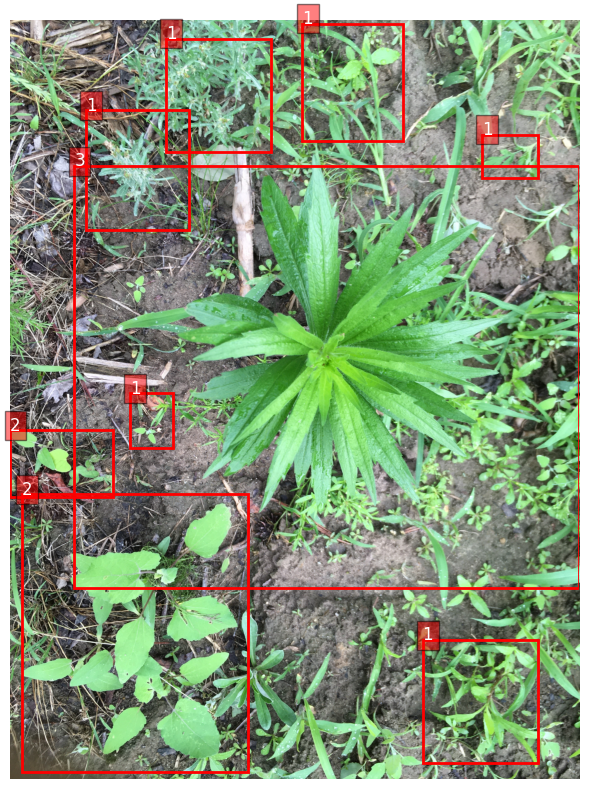

In [23]:
import torchvision.ops as ops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms
import numpy as np
import cv2

def apply_nms_and_visualize(model, img_path, device, score_threshold=0.1, iou_threshold=0.1):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)

    # Get the boxes, labels, and scores from the model's prediction
    scores = prediction[0]['scores'].cpu().numpy()
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Filter out low confidence predictions (based on score_threshold)
    high_confidence_idx = np.where(scores >= score_threshold)[0]
    boxes = boxes[high_confidence_idx]
    labels = labels[high_confidence_idx]
    scores = scores[high_confidence_idx]

    # Apply Non-Maximum Suppression (NMS)
    keep = ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)

    # Visualize the results
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Plot the boxes and labels for the final detections after NMS
    for idx in keep:
        x_min, y_min, x_max, y_max = boxes[idx]
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{labels[idx]}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
apply_nms_and_visualize(model, '/content/drive/MyDrive/CottonWeedDet3/images/20200612_iPhoneSE_B_5.jpg', device)


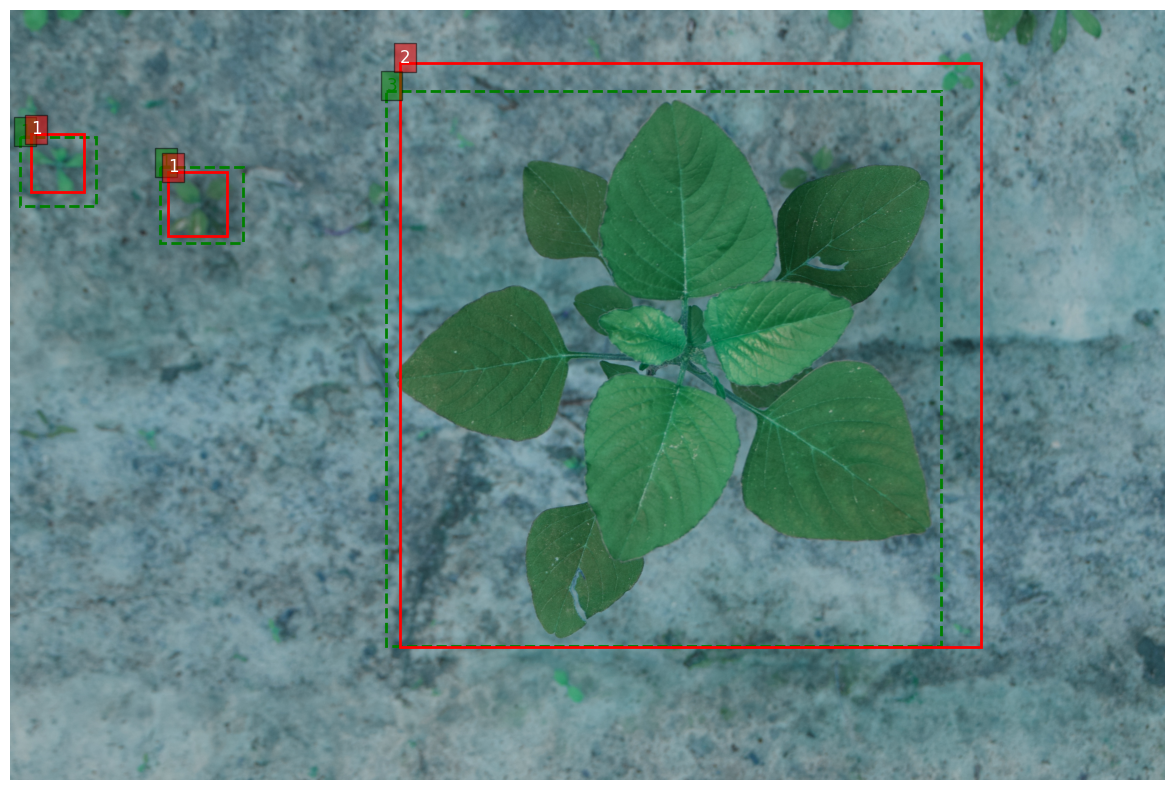

In [24]:
import torchvision.ops as ops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms
import numpy as np
import cv2

def apply_nms_and_visualize(model, dataset, idx, device, score_threshold=0.01, iou_threshold=0.01):
    # Load the image and its ground truth annotation from the dataset
    image, target = dataset[idx]  # Get image and target from the dataset
    img = np.array(image.permute(1, 2, 0))  # Convert the image tensor to a NumPy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    # Ground truth boxes and labels
    ground_truth_boxes = target['boxes'].cpu().numpy()
    ground_truth_labels = target['labels'].cpu().numpy()

    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    # Get the boxes, labels, and scores from the model's prediction
    scores = prediction[0]['scores'].cpu().numpy()
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Filter out low confidence predictions (based on score_threshold)
    high_confidence_idx = np.where(scores >= score_threshold)[0]
    boxes = boxes[high_confidence_idx]
    labels = labels[high_confidence_idx]
    scores = scores[high_confidence_idx]

    # Apply Non-Maximum Suppression (NMS)
    keep = ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)

    # Visualize the results
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Plot the ground truth boxes in green (dashed lines)
    for gt_box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
        x_min, y_min, x_max, y_max = gt_box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='g', facecolor='none', linestyle='--'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{gt_label}', fontsize=12, color='green', bbox=dict(facecolor='green', alpha=0.5))

    # Plot the predicted boxes in red
    for idx in keep:
        x_min, y_min, x_max, y_max = boxes[idx]
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{labels[idx]}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
# Let's assume 'dataset' is your WeedDataset object
# Pass the index of the image you want to visualize (e.g., idx=0)
apply_nms_and_visualize(model, dataset, idx=667, device=device)


In [ ]:
import torchvision.ops as ops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms
import numpy as np
import cv2

def apply_nms_and_visualize(model, dataset, idx, device, score_threshold=0.01, iou_threshold=0.01):
    # Load the image and its ground truth annotation from the dataset
    image, target = dataset[idx]  # Get image and target from the dataset
    img = np.array(image.permute(1, 2, 0))  # Convert the image tensor to a NumPy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    # Ground truth boxes and labels
    ground_truth_boxes = target['boxes'].cpu().numpy()
    ground_truth_labels = target['labels'].cpu().numpy()

    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    # Get the boxes, labels, and scores from the model's prediction
    scores = prediction[0]['scores'].cpu().numpy()
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Filter out low confidence predictions (based on score_threshold)
    high_confidence_idx = np.where(scores >= score_threshold)[0]
    boxes = boxes[high_confidence_idx]
    labels = labels[high_confidence_idx]
    scores = scores[high_confidence_idx]

    # Apply Non-Maximum Suppression (NMS)
    keep = ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)

    # Visualize the results
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Plot the ground truth boxes in green (dashed lines)
    for gt_box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
        x_min, y_min, x_max, y_max = gt_box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='g', facecolor='none', linestyle='--'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{gt_label}', fontsize=12, color='green', bbox=dict(facecolor='green', alpha=0.5))

    # Plot the predicted boxes in red
    for idx in keep:
        x_min, y_min, x_max, y_max = boxes[idx]
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{labels[idx]}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
# Let's assume 'dataset' is your WeedDataset object
# Pass the index of the image you want to visualize (e.g., idx=0)
apply_nms_and_visualize(model, dataset, idx=667, device=device)


In [25]:
# Define the path in your Google Drive where you want to save the model
# Make sure the directory exists
google_drive_path = '/content/drive/MyDrive/CottonWeedDet3/rcnn_model_FPN.pth'

# Save the model's state dictionary to Google Drive
torch.save(model.state_dict(), google_drive_path)

print(f"Model state dictionary saved to {google_drive_path}")

Model state dictionary saved to /content/drive/MyDrive/CottonWeedDet3/rcnn_model_FPN.pth


In [26]:
import torch

# Function to save model state
def save_model(model, optimizer, epoch, loss, save_path):
    # Save model checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,  # Optionally save loss (or any other metrics you want)
    }

    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")

# Example usage
save_path = '/content/drive/MyDrive/CottonWeedDet3/fasterrcnn_model_FPN.pth'
save_model(model, optimizer, epoch=10, loss=0.05, save_path=save_path)


Model saved to /content/drive/MyDrive/CottonWeedDet3/fasterrcnn_model_FPN.pth


In [28]:
from tqdm import tqdm
import torch

# Function to compute the IoU (Intersection over Union)
def compute_iou(pred_boxes, target_boxes):
    x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    intersection_area = torch.max(x2 - x1, torch.zeros_like(x1)) * torch.max(y2 - y1, torch.zeros_like(y1))

    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])

    union_area = pred_area + target_area - intersection_area

    iou = intersection_area / union_area
    return iou

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

# Initialize variables to track the total IoU, Precision, Recall, and AP
total_iou = 0.0
total_precision = 0.0
total_recall = 0.0
total_tp = 0
total_fp = 0
total_fn = 0
num_samples = 0

# Use tqdm to add a progress bar for test set evaluation
with torch.no_grad():  # No need to compute gradients during evaluation
    for images, targets in tqdm(val_loader, desc="Evaluating Test Set", dynamic_ncols=True):
        # Move images and targets to the appropriate device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass through the model
        predictions = model(images)

        # Compute IoU, Precision, Recall for the predicted and ground truth boxes
        for i in range(len(targets)):
            if 'boxes' in predictions[i] and predictions[i]['boxes'].numel() > 0 and targets[i]['boxes'].numel() > 0:
                pred_boxes = predictions[i]['boxes']
                target_boxes = targets[i]['boxes']

                # Handle the case where the number of predicted boxes doesn't match the number of ground truth boxes
                if len(pred_boxes) > len(target_boxes):
                    pred_boxes = pred_boxes[:len(target_boxes)]
                elif len(target_boxes) > len(pred_boxes):
                    padding = torch.zeros(len(target_boxes) - len(pred_boxes), 4, device=device)
                    pred_boxes = torch.cat((pred_boxes, padding), dim=0)

                # Calculate IoU for all combinations of predicted and target boxes
                iou_matrix = compute_iou(pred_boxes, target_boxes)

                # Find the maximum IoU for each ground truth box
                max_iou_for_targets = torch.max(iou_matrix, dim=0)[0]

                # Calculate TP, FP, FN for Precision and Recall
                tp = torch.sum(max_iou_for_targets > 0.5).item()  # True positives: IoU > 0.5
                fp = len(pred_boxes) - tp  # False positives: predicted boxes that don't match any ground truth
                fn = len(target_boxes) - tp  # False negatives: ground truth boxes that are not matched

                # Update total TP, FP, FN
                total_tp += tp
                total_fp += fp
                total_fn += fn

                # Sum the maximum IoUs
                total_iou += torch.sum(max_iou_for_targets).item()
                num_samples += len(target_boxes)

    # Calculate metrics
    avg_iou = total_iou / num_samples if num_samples > 0 else 0.0
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0

    # Calculate average Precision
    # For simplicity, we assume precision/recall calculation for each class
    average_precision = precision  # This would ideally be averaged over all classes in mAP calculation

    # Print results
    print(f"Test Set Evaluation Results:")
    print(f"  - Average IoU: {avg_iou:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - Average Precision: {average_precision:.4f}")


Evaluating Test Set: 100%|██████████| 43/43 [03:36<00:00,  5.04s/it]

Test Set Evaluation Results:
  - Average IoU: 0.3375
  - Precision: 0.4013
  - Recall: 0.4013
  - Average Precision: 0.4013
